# How to use `tesswcs`

The `tesswcs` package is designed to help users:

1. Obtain the **true** World Coordinate System for TESS (Transiting Exoplanet Survey Satellite) data that is **archived**.
2. Predict the World Coordinate System for TESS Cameras and CCDs based on an RA (Right Ascension), Dec (Declination), and Roll pointing of the boresight.

In this tutorial, we show how to work with the `tesswcs` package to get pointing information for the telescope.

## A brief recap on WCS

The World Coordinate System (WCS) is a standard in astronomy for representing coordinates of celestial objects. It's a system that maps the pixels of an image to real-world coordinates (like RA and Dec in the sky). This is crucial for understanding where exactly an astronomical image is pointing. WCS information in this case will enable us to understand which targets will fall on TESS pixels for any given pointing of the spacecraft.

WCS information is typically stored in the header of FITS (Flexible Image Transport System) files, a common file format used in astronomy. The WCS headers contain the necessary parameters to translate between pixel coordinates in the image and sky coordinates.

## A brief recap on `astropy.wcs.WCS`

`astropy.wcs.WCS` is a class provided by the [Astropy package](https://www.astropy.org/), a powerful tool for astronomy data analysis and handling in Python. The `WCS` class in Astropy is used to handle the World Coordinate System information of FITS files.

This class can parse the WCS information from FITS headers and provide a simple interface to convert between pixel coordinates and sky coordinates. Some common operations using `astropy.wcs.WCS` include:

- Converting pixel coordinates to celestial coordinates and vice versa.
- Handling different types of projections and coordinate transformations.
- Dealing with distortions present in the data.

## What is new in `tesswcs.WCS`?
`tesswcs` provides you with a "subclass" of `astropy.wcs.WCS`. **As such, the `tesswcs.WCS` class provides the same functionality as `astropy.wcs.WCS`, including working with WCS objects and storing them as fits files.** The `tesswcs.WCS` has new methods and attributes, which enables you to do the following;

### New class methods

To create the WCS for tess you can use one of two class methods. To obtain the **true** WCS from an **archived** dataset, you can use

```python
wcs = tesswcs.WCS.from_archive(sector=1, camera=1, ccd=1)
```

To predict a WCS based on a boresight RA, Dec and Roll, you can use
```python
wcs = tesswcs.WCS.predict(ra=352.6844, dec=-64.8531, roll=222.1532, sector=1, camera=1, ccd=1)
```

### New class attributes

If you initialize a `tesswcs.WCS` class object
```python
wcs = tesswcs.WCS.from_sector(sector=1, camera=1, ccd=1)
```

you can access the RA, Dec, and Roll of the *boresight* pointing of TESS using class attributes, e.g.
```python
wcs.ra, wcs.dec, wcs.roll
```
will return 
```python
(352.6844, -64.8531, 222.1532)
```

and you can access the camera and CCD number 
```python
wcs.camera, wcs.ccd
```
will return
```python
(1, 1)
```

You can also access the sector, e.g.

```python
wcs.sector
```
will return 
```python
1
```

## How do I use it?

Below we show a tutorial on how to work with the `tesswcs.WCS` class.

In [1]:
from tesswcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

First, to load a WCS from TESS data that has already been archived, we can use the `from_archive` method:

In [2]:
wcs = WCS.from_sector(sector=1, camera=1, ccd=1)

If we print `wcs`, can see the key parameters of the WCS

In [3]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 319.40344268202983 -41.281972194879756 
CRPIX : 1045.0 1001.0 
PC1_1 PC1_2  : 0.005481380474769502 -0.001728607226633 
PC2_1 PC2_2  : 0.001590229789019981 0.005438735789549773 
CDELT : 1.0 1.0 
NAXIS : 2078  2136

Remember, the `tesswcs.WCS` has special attributes, the `ra`, `dec`, and `roll` attributes show the properties of the **boresight**.

In [4]:
wcs.ra, wcs.dec, wcs.roll

(352.6844, -64.8531, 222.1532)

To show that `tesswcs` is able to accurately predict the WCS of a TESS camera and CCD given the boresight RA, Dec, and Roll, let's create a predicted WCS. To predict a WCS we use the `predict` method, and pass an RA, Dec and Roll. 

In [5]:
wcs_predicted = WCS.predict(wcs.ra, wcs.dec, wcs.roll, camera=1, ccd=1)

In [6]:
wcs_predicted

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 319.4158285479007 -41.27265773149455 
CRPIX : 1047.0643136919077 1002.0961710627299 
PC1_1 PC1_2  : -0.005481123840576269 0.0017292253510473817 
PC2_1 PC2_2  : 0.0015909063291915848 0.005438659407059995 
CDELT : -1.0 1.0 
NAXIS : 2078  2136

You can see the predicted WCS has slightly different properties, (e.g. the predicted WCS uses a different origin in pixel space).

Let's compare the world coordinates that would be given by pixels on the detector in each case.

In [7]:
# Build a pixel grid, note we include collateral pixels
R, C = np.meshgrid(
    np.arange(0, 2078, 10), np.arange(0, 2136, 10), indexing="ij"
)

Below we plot the pixel grid

[Text(0.5, 0, 'Column [pixel]'),
 Text(0, 0.5, 'Row [pixel]'),
 Text(0.5, 1.0, 'Sector 1, Camera 1, CCD 1')]

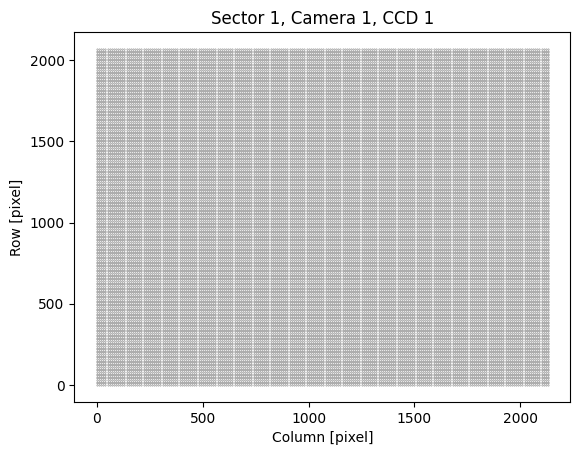

In [8]:
fig, ax = plt.subplots()
ax.scatter(C, R, s=0.1, color='grey', label='True Measured WCS')
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title="Sector 1, Camera 1, CCD 1")

Since `WCS` is a subclass of `astropy.wcs.WCS` we can use the `pixel_to_world` method

In [9]:
c = wcs.pixel_to_world(R, C)

`c` now contains the sky coordinates for those pixel positions. Let's plot them.

[Text(0.5, 0, 'RA [deg]'),
 Text(0, 0.5, 'Dec [deg]'),
 Text(0.5, 1.0, 'Sector 1, Camera 1, CCD 1')]

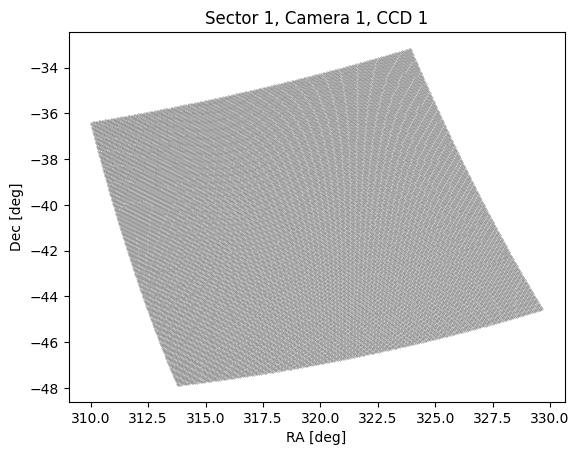

In [10]:
fig, ax = plt.subplots()
ax.scatter(c.ra.deg, c.dec.deg, s=0.1, color='grey', label='True Measured WCS')
ax.set(xlabel='RA [deg]', ylabel='Dec [deg]', title="Sector 1, Camera 1, CCD 1")

Looks great. Now we can plot the predicted coordinates for the same RA, Dec, and Roll as sector 1.

In [11]:
c_predicted = wcs_predicted.pixel_to_world(R, C)

[Text(0.5, 0, 'RA [deg]'),
 Text(0, 0.5, 'Dec [deg]'),
 Text(0.5, 1.0, 'Sector 1, Camera 1, CCD 1')]

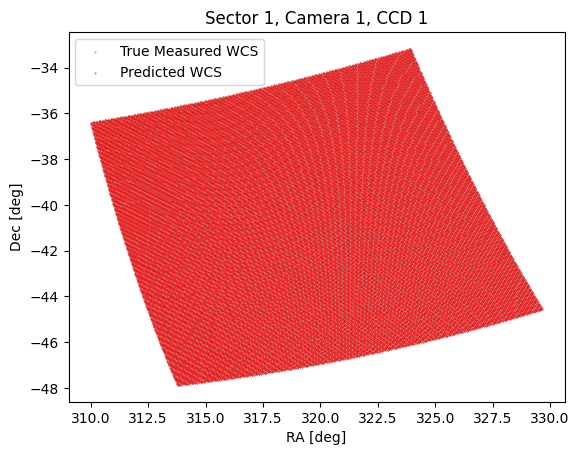

In [12]:
fig, ax = plt.subplots()
ax.scatter(c.ra.deg, c.dec.deg, s=0.1, color='grey', label='True Measured WCS')
ax.scatter(c_predicted.ra.deg, c_predicted.dec.deg, s=0.1, color='red', label='Predicted WCS')
ax.legend()
ax.set(xlabel='RA [deg]', ylabel='Dec [deg]', title="Sector 1, Camera 1, CCD 1")

These look very close! Let's look at the separation between the truth and the prediction as a function of pixel position.

In [13]:
sep = np.hypot(c.ra - c_predicted.ra, c.dec - c_predicted.dec).to('arcsec')

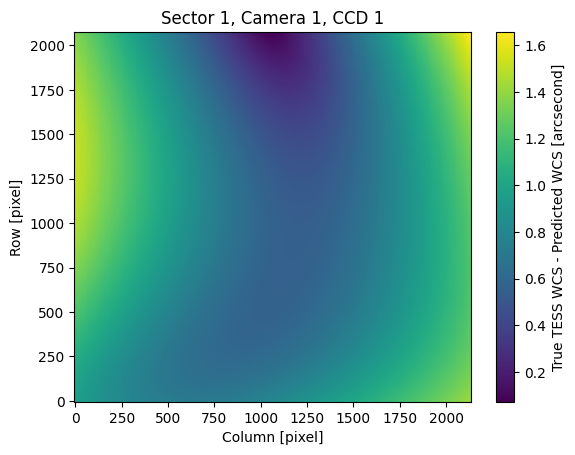

In [14]:
fig, ax = plt.subplots()
im = ax.pcolormesh(C, R, sep.value)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("True TESS WCS - Predicted WCS [arcsecond]")
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title="Sector 1, Camera 1, CCD 1");

Given that a TESS pixel is 21 arcseconds across, the prediction is within a tenth of a pixel across the detector!

The `tesswcs.WCS.predict` method is generally accurate to a fraction of a pixel.

# Creating new WCS based on pointing information

Some TESS sectors have not yet been observed, and therefore there is no WCS data archived for those sectors. In these cases, we can predict the WCS based on the RA, Dec and Roll for the upcoming sectors. 

`tesswcs` stores the pointing data for all TESS sectors in the `pointings` variable, to make this easier.

Below we show how to predict the WCS for a future TESS pointing from the upcoming Cycle 7.

In [15]:
# We will need to use astropy units for plotting
import astropy.units as u
# The `footprint` function is a convenience function to obtain the edges of the CCD
from tesswcs.utils import footprint

# We will also create an ecliptic plane vector for plotting purposes
from astropy.coordinates import SkyCoord
ecliptic_plane = SkyCoord(np.arange(0, 360, 1), np.arange(0, 360, 1)*0, unit='deg', frame='geocentricmeanecliptic').transform_to('icrs')

First we get the pointing data for a sector in cycle 7

In [16]:
from tesswcs import pointings

In [17]:
sector = 90
pointings[pointings['Sector'] == sector]

Cycle,Sector,RA,Dec,Roll,Start,End
int64,int64,float64,float64,float64,float64,float64
7,90,155.0705,-51.7243,141.9459,2460746.5,2460774.5


We only need RA, Dec, and Roll

In [18]:
# Boresight RA, Dec, and Roll
ra, dec, roll = np.asarray(pointings[pointings['Sector'] == sector][['RA', 'Dec', 'Roll']])[0]

We can obtain the predicted WCS for this roll for any camera and CCD using the following

In [19]:
wcs = WCS.predict(ra, dec, roll, camera=1, ccd=1)

Below we show a short script to plot the edges of each CCD in this sector in a Mollweide projection

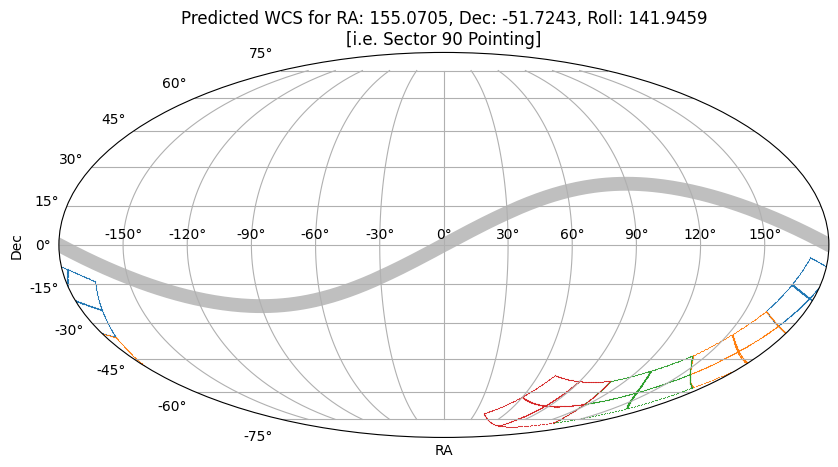

In [20]:
# Set up plot parameters
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
ax.set(
    title=f"Predicted WCS for RA: {ra}, Dec: {dec}, Roll: {roll}\n[i.e. Sector {sector} Pointing]",
    xlabel="RA",
    ylabel="Dec",
)
# Plot the ecliptic plane
s = np.argsort(ecliptic_plane.ra.wrap_at(180 * u.deg).rad)
plt.plot(ecliptic_plane.ra.wrap_at(180 * u.deg).rad[s], ecliptic_plane.dec.rad[s], color='grey', zorder=-10, alpha=0.5, lw=10)

# iterate over camera, CCD
for camera in np.arange(1, 5):
    for ccd in np.arange(1, 5):
        # predict the WCS
        wcs = WCS.predict(ra, dec, roll, camera=camera, ccd=ccd)
        # create world coordinates from a pixel footprint
        c = wcs.pixel_to_world(*footprint().T)

        # Plot each camera/CCD
        ax.scatter(
            c.ra.wrap_at(180 * u.deg).rad,
            c.dec.rad,
            lw=0.5,
            s=0.1,
            c=f"C{camera - 1}",
        )

## Creating a WCS based on an RA, Dec, and Roll

Sometimes we may want to obtain a WCS for a theoretical pointing of the spacecraft. To do so you can easily add your own boresight RA, Dec, and Roll. Below I show the same proceedure as above for a random pointing.

In [21]:
# Boresight RA, Dec, and Roll
ra, dec, roll = 239.4578, 12.56087, 42.45899

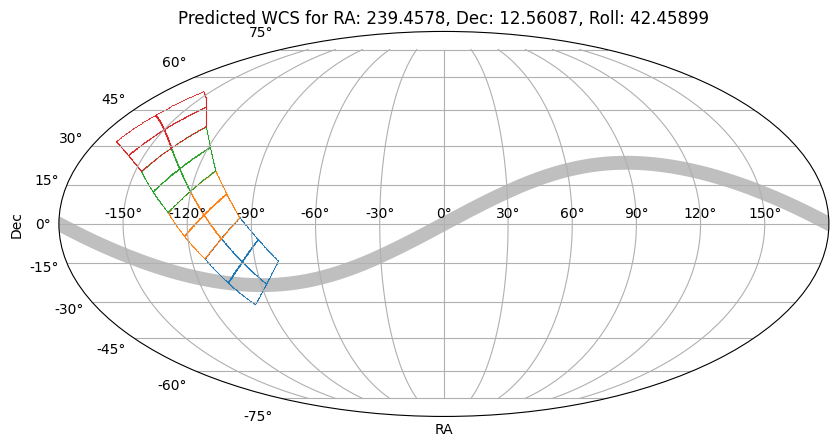

In [22]:
# Set up plot parameters
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
ax.set(
    title=f"Predicted WCS for RA: {ra}, Dec: {dec}, Roll: {roll}",
    xlabel="RA",
    ylabel="Dec",
)
# Plot the ecliptic plane
s = np.argsort(ecliptic_plane.ra.wrap_at(180 * u.deg).rad)
plt.plot(ecliptic_plane.ra.wrap_at(180 * u.deg).rad[s], ecliptic_plane.dec.rad[s], color='grey', zorder=-10, alpha=0.5, lw=10)


# iterate over camera, CCD
for camera in np.arange(1, 5):
    for ccd in np.arange(1, 5):
        # predict the WCS
        wcs = WCS.predict(ra, dec, roll, camera=camera, ccd=ccd)
        # create world coordinates from a pixel footprint
        c = wcs.pixel_to_world(*footprint().T)

        # Plot each camera/CCD
        ax.scatter(
            c.ra.wrap_at(180 * u.deg).rad,
            c.dec.rad,
            lw=0.5,
            s=0.1,
            c=f"C{camera - 1}",
        )

## Using the WCS Object to find if objects are observable in TESS

Now that we have a WCS will want to use it. The key use case of WCS is a way to convert between sky positions of targets, and pixel positions on the detector. 

Let's take a look at an exoplanet target. First we obtain the coordinates as an `astropy.coordinates.SkyCoord` object, using the `from_name` class method.

In [23]:
c_targ = SkyCoord.from_name('HD209458')

In [24]:
c_targ

<SkyCoord (ICRS): (ra, dec) in deg
    (330.79488644, 18.88431928)>

Now that we have the coordinate that we want, let's see if it is observable in Cycle 6. First we need to know what sectors were taken during cycle 6.

In [25]:
sectors = pointings['Sector'][pointings['Cycle'] == 6].data
sectors

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

Using the `pointings` table we can see it's sectors 70 through 83. 

We can now build the WCS for TESS each of those sectors. For each camera and CCD, we use the `footprint_contains` method to check if the target is contained within the CCD.

In [26]:
observable = []
for sector in sectors:
    ra, dec, roll = pointings[sector - 1][['RA', 'Dec', 'Roll']]
    for camera in np.arange(1, 5):
        for ccd in np.arange(1, 5):
            # predict the WCS
            wcs = WCS.predict(ra, dec, roll, camera=camera, ccd=ccd)
            # check if the target falls inside the CCD
            if wcs.footprint_contains(c_targ):
                print(f"Target Observable in Sector {sector}, Camera {camera}, CCD {ccd}")

Target Observable in Sector 82, Camera 1, CCD 1


It looks like the target is observable in sector 82! Let's find out what pixel the target will fall on

In [27]:
sector = 82
ra, dec, roll = pointings[sector - 1][['RA', 'Dec', 'Roll']]
wcs = WCS.predict(ra, dec, roll, camera=1, ccd=1)

In [28]:
row_pixel, column_pixel = wcs.world_to_pixel(c_targ)

In [29]:
row_pixel, column_pixel

(array(504.27292491), array(454.26318527))

It looks like this target will fall on row 506, column 454. Keep in mind, this **includes collateral pixels**! You can read more about collateral pixels on TESS CCDs [here](https://heasarc.gsfc.nasa.gov/docs/tess/data-products.html).